In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install --upgrade --no-cache-dir gdown

In [3]:
!gdown --id 178CNCisWQNbPzaj5MSEWI5KtPodLDlPv

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=178CNCisWQNbPzaj5MSEWI5KtPodLDlPv
From (redirected): https://drive.google.com/uc?id=178CNCisWQNbPzaj5MSEWI5KtPodLDlPv&confirm=t&uuid=c25f1937-82cf-4cf9-930d-6730ae5f3a5b
To: /kaggle/working/final_data.zip
100%|██████████████████████████████████████| 1.47G/1.47G [00:18<00:00, 80.7MB/s]


In [4]:
from zipfile import ZipFile

file_name = "/kaggle/working/final_data.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [5]:
import numpy as np
import pandas as pd
import os
import keras
import tensorflow as tf
import cv2
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [6]:
#get the classnames  programmatically
import pathlib
data_dir=pathlib.Path("/kaggle/working/data/train")
class_names=np.array(sorted([item.name for item in data_dir.glob("*")])) # created a list of class_names from the sub directories
print(class_names)

['Acne and Rosacea Photos'
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions'
 'Eczema Photos' 'Melanoma Skin Cancer Nevi and Moles'
 'Nail Fungus and other Nail Disease'
 'Psoriasis pictures Lichen Planus and related diseases'
 'Seborrheic Keratoses and other Benign Tumors' 'Systemic Disease'
 'Tinea Ringworm Candidiasis and other Fungal Infections'
 'Warts Molluscum and other Viral Infections']


In [7]:
#visualize 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import random

def view_random_image(target_dir,target_class):
  target_folder=target_dir+target_class

  random_image=random.sample(os.listdir(target_folder),1)
  img=mpimg.imread(target_folder+"/"+random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape : {img.shape}")
  return img

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [10]:
train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/data/train',
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/working/data/test',
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical'
)

Found 10495 images belonging to 10 classes.
Found 4936 images belonging to 10 classes.


In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))

In [12]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)


In [14]:
# Train the model
history=model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=70,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

Epoch 1/70
82/82 [==============================] - 168s 2s/step - loss: 1.9672 - accuracy: 0.2806 - val_loss: 1.9680 - val_accuracy: 0.2820
Epoch 2/70
82/82 [==============================] - 168s 2s/step - loss: 1.9074 - accuracy: 0.3138 - val_loss: 1.9343 - val_accuracy: 0.2968
Epoch 3/70
82/82 [==============================] - 170s 2s/step - loss: 1.8642 - accuracy: 0.3334 - val_loss: 1.8523 - val_accuracy: 0.3339
Epoch 4/70
82/82 [==============================] - 167s 2s/step - loss: 1.8199 - accuracy: 0.3456 - val_loss: 1.8277 - val_accuracy: 0.3444
Epoch 5/70
82/82 [==============================] - 169s 2s/step - loss: 1.7741 - accuracy: 0.3678 - val_loss: 1.7684 - val_accuracy: 0.3896
Epoch 6/70
82/82 [==============================] - 164s 2s/step - loss: 1.7345 - accuracy: 0.3792 - val_loss: 1.7602 - val_accuracy: 0.3861
Epoch 7/70
82/82 [==============================] - 164s 2s/step - loss: 1.7185 - accuracy: 0.3838 - val_loss: 1.7231 - val_accuracy: 0.3916
Epoch 8/70
82

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import save_model
import IPython
import os

In [17]:
# Specify the path where you want to save the model in the Kaggle output directory
save_path = '/kaggle/working/model.h5'

# Save the model to the specified path
model.save(save_path)


In [19]:
model.evaluate(test_generator)

39/39 [==============================] - 22s 556ms/step - loss: 1.1648 - accuracy: 0.7050


[1.1647601127624512, 0.7050243020057678]

In [20]:
#check loss curves
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

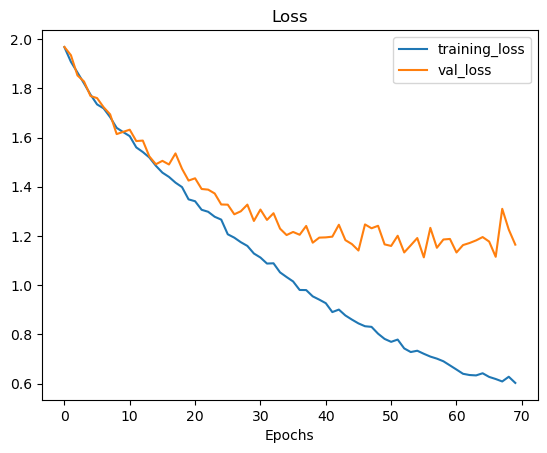

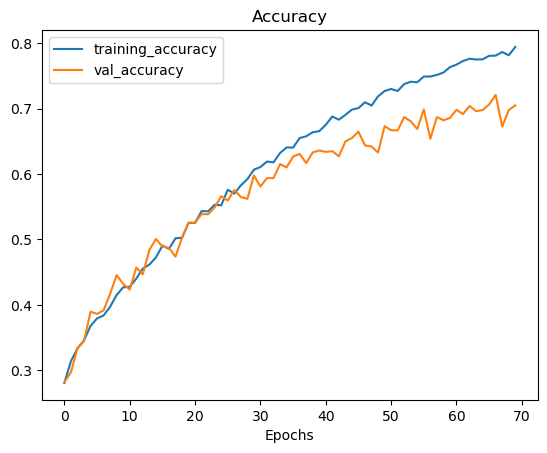

In [21]:
plot_loss_curves(history)

In [22]:

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [23]:

# Load in and preprocess our custom image
example = load_and_prep_image("/kaggle/input/testing-img/2.jpg")
example

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[4.0276114e-02, 8.9035593e-03, 2.0008003e-03],
        [5.1280513e-02, 1.2064825e-02, 4.2216871e-03],
        [5.7262909e-02, 1.4125652e-02, 7.1828743e-03],
        ...,
        [7.8860980e-01, 5.9253138e-01, 5.5303520e-01],
        [7.9095393e-01, 6.0271865e-01, 5.6350297e-01],
        [7.5034165e-01, 5.6602794e-01, 5.2681226e-01]],

       [[4.3277312e-02, 1.1904761e-02, 2.5010002e-03],
        [4.5318123e-02, 6.8627433e-03, 9.0035924e-04],
        [6.5226085e-02, 2.2088835e-02, 1.4245697e-02],
        ...,
        [7.3685747e-01, 5.4077899e-01, 4.9764177e-01],
        [7.8259593e-01, 5.9436065e-01, 5.5514497e-01],
        [8.6992723e-01, 6.8561345e-01, 6.4639777e-01]],

       [[4.0756304e-02, 8.5434206e-03, 5.6022569e-04],
        [5.0640259e-02, 7.5030047e-03, 7.4029813e-04],
        [6.1284512e-02, 1.1844739e-02, 9.2236893e-03],
        ...,
        [7.4061954e-01, 5.4454112e-01, 5.0140387e-01],
        [8.2264882e-01

In [25]:
# Add an extra axis
print(f"Shape before new dimension: {example.shape}")
example = tf.expand_dims(example, axis=0) # add an extra dimension at axis 0
#steak = steak[tf.newaxis, ...] # alternative to the above, '...' is short for 'every other dimension'
print(f"Shape after new dimension: {example.shape}")
example

Shape before new dimension: (224, 224, 3)
Shape after new dimension: (1, 224, 224, 3)


<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[4.0276114e-02, 8.9035593e-03, 2.0008003e-03],
         [5.1280513e-02, 1.2064825e-02, 4.2216871e-03],
         [5.7262909e-02, 1.4125652e-02, 7.1828743e-03],
         ...,
         [7.8860980e-01, 5.9253138e-01, 5.5303520e-01],
         [7.9095393e-01, 6.0271865e-01, 5.6350297e-01],
         [7.5034165e-01, 5.6602794e-01, 5.2681226e-01]],

        [[4.3277312e-02, 1.1904761e-02, 2.5010002e-03],
         [4.5318123e-02, 6.8627433e-03, 9.0035924e-04],
         [6.5226085e-02, 2.2088835e-02, 1.4245697e-02],
         ...,
         [7.3685747e-01, 5.4077899e-01, 4.9764177e-01],
         [7.8259593e-01, 5.9436065e-01, 5.5514497e-01],
         [8.6992723e-01, 6.8561345e-01, 6.4639777e-01]],

        [[4.0756304e-02, 8.5434206e-03, 5.6022569e-04],
         [5.0640259e-02, 7.5030047e-03, 7.4029813e-04],
         [6.1284512e-02, 1.1844739e-02, 9.2236893e-03],
         ...,
         [7.4061954e-01, 5.4454112e-01, 5.0140387e-01],


In [26]:
pred = model.predict(example)
pred

1/1 [==============================] - 0s 292ms/step


array([[9.9826318e-01, 1.1881665e-05, 1.4125903e-05, 3.6455808e-07,
        2.1096478e-06, 8.9877483e-04, 2.5349212e-04, 1.4949431e-06,
        5.3895410e-04, 1.5594611e-05]], dtype=float32)

In [27]:
class_names

array(['Acne and Rosacea Photos',
       'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
       'Eczema Photos', 'Melanoma Skin Cancer Nevi and Moles',
       'Nail Fungus and other Nail Disease',
       'Psoriasis pictures Lichen Planus and related diseases',
       'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease',
       'Tinea Ringworm Candidiasis and other Fungal Infections',
       'Warts Molluscum and other Viral Infections'], dtype='<U66')

1/1 [==============================] - 0s 20ms/step


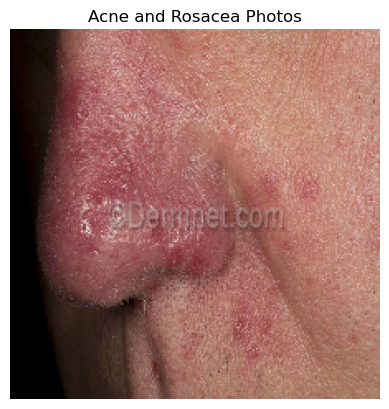

In [28]:
img = load_and_prep_image("/kaggle/input/testing-img/2.jpg")

# Make a prediction
pred = model.predict(tf.expand_dims(img, axis=0))

# Match the prediction class to the highest prediction probability
pred_class = class_names[pred.argmax()]
plt.imshow(img)
plt.title(pred_class)
plt.axis(False);

In [29]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

1/1 [==============================] - 0s 20ms/step


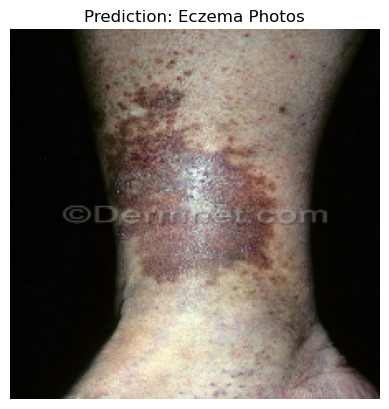

In [30]:
pred_and_plot(model, "/kaggle/input/testing-img/3.jpg", class_names)

1/1 [==============================] - 0s 20ms/step


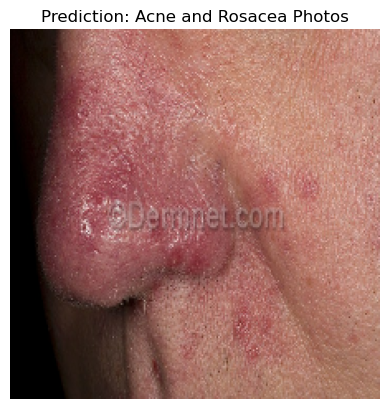

In [31]:
pred_and_plot(model,"/kaggle/input/testing-img/2.jpg",class_names)